# Exploratory Data Analysis & Feature Engineering (Following the first Assignment)

This notebook is dedicated exclusively to Exploratory Data Analysis and Feature Engineering, following the methodology established in the first assignment. It focuses on understanding data distributions, identifying patterns, handling missing values, and preparing features for modeling.

The insights and preprocessing steps identified during this EDA were later incorporated into a unified pipeline-based processing approach, ensuring consistency, reproducibility, and seamless integration with the model training and evaluation workflows which are done in seperate notebooks.

In [1]:
#import the required packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)


# Data Splitting
---
**Objective:** Partition the TelcoChun| dataset into **Training** and **Testing** sets to ensure unbiased model evaluation.

In [2]:
# Load initial dataset downloaded from Kaggle https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download 
df = pd.read_csv("../WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop customerID (not useful for ML)
df.drop(columns=["customerID"], inplace=True)

# Split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Churn"]
)

# Save CSVs
train_df.to_csv("../dataset/telco_train.csv", index=False)
test_df.to_csv("../dataset/telco_test.csv", index=False)

print("Train & Test CSV files created")

Train & Test CSV files created


In [3]:
#Data Size : How many total data entries (observations) are present? How many features (variables) are there, including the target column
df = pd.read_csv("../dataset/telco_train.csv")
#data_frame.shape retruns the tuple and [0] returns the element of the tuples correspondingly.
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df.head()

Rows: 5634
Columns: 20


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


In [4]:
# Fix TotalCharges issue
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
# ---- Custom Feature Engineering ----
df["AvgChargesPerMonth"] = df["TotalCharges"] / df["tenure"]
df["Is_Long_Term_Customer"] = (df["tenure"] > 24).astype(int)
df['Fiber_and_MonthToMonth'] = ((df['InternetService'] == 'Fiber optic') & 
                                (df['Contract'] == 'Month-to-month')).astype(int)
### Effect of Derived Features
#Custom derived features were introduced to capture business intuition around customer tenure and billing behavior. However, model performance remained largely unchanged. 
#This suggests that the original features already encode sufficient information and that the derived features are highly correlated with existing variables. 
#The result highlights the robustness of the baseline model and the importance of empirical validation when adding new features.

#Separate Features & Target
X = df.drop(columns=['Churn'])
#Target Encoding . Convert target variable Churn.
print("Before Target Encoding : ", df['Churn'].value_counts())
y = df['Churn'].map({'Yes': 1, 'No': 0})
print("After Target Encoding : ",y.value_counts())
df["Churn"].value_counts(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Split Training Set and Test Set
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Before Target Encoding :  Churn
No     4139
Yes    1495
Name: count, dtype: int64
After Target Encoding :  Churn
0    4139
1    1495
Name: count, dtype: int64
X_train shape: (4507, 22)
X_test shape: (1127, 22)
y_train shape: (4507,)
y_test shape: (1127,)


In [6]:
#Examine the missing values in the dataset size.A cell with no data is called “missing.”
print("Missing values per column:")
print(X_train.isnull().sum())
#There are no columns with Missing Values as per the recieved output

Missing values per column:
gender                    0
SeniorCitizen             0
Partner                   0
Dependents                0
tenure                    0
PhoneService              0
MultipleLines             0
InternetService           0
OnlineSecurity            0
OnlineBackup              0
DeviceProtection          0
TechSupport               0
StreamingTV               0
StreamingMovies           0
Contract                  0
PaperlessBilling          0
PaymentMethod             0
MonthlyCharges            0
TotalCharges              7
AvgChargesPerMonth        7
Is_Long_Term_Customer     0
Fiber_and_MonthToMonth    0
dtype: int64


In [7]:
#Feature Types: What kind of data does each column have?
print("Column types:")
print(X_train.dtypes)
#Feature Types: More detailed view to know what kind of data does each column have? Data --> Numerical or Categorical
categorical_cols = []
numerical_cols = []
numerical_disguised_as_object = []
id_cols = []

n_rows = len(X_train)

for col in X_train.columns:

    # Detect ID-like columns
    if X_train[col].dtype == 'object' and X_train[col].nunique() / n_rows > 0.95:
        id_cols.append(col)
        continue

    # Proper numeric columns
    if X_train[col].dtype in ['int64', 'float64']:
        if X_train[col].nunique() < 10:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)

    # Object but numeric
    elif X_train[col].dtype == 'object':
        converted = pd.to_numeric(X_train[col], errors='coerce')
        if converted.notna().mean() > 0.9:
            numerical_cols.append(col)
            numerical_disguised_as_object.append(col)
        else:
            categorical_cols.append(col)

    # Other
    else:
        categorical_cols.append(col)

print("ID Columns:", id_cols)
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)
print("Numerical but stored as object:", numerical_disguised_as_object)




Column types:
gender                     object
SeniorCitizen               int64
Partner                    object
Dependents                 object
tenure                      int64
PhoneService               object
MultipleLines              object
InternetService            object
OnlineSecurity             object
OnlineBackup               object
DeviceProtection           object
TechSupport                object
StreamingTV                object
StreamingMovies            object
Contract                   object
PaperlessBilling           object
PaymentMethod              object
MonthlyCharges            float64
TotalCharges              float64
AvgChargesPerMonth        float64
Is_Long_Term_Customer       int64
Fiber_and_MonthToMonth      int64
dtype: object
ID Columns: []
Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']
Categorical Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService

In [8]:
#Detect Semantic Missing Values. These are the missing values which cannot be detected using df.isnull().sum()
semantic_missing = ["", " ", "NA", "N/A", "null", "None", "unknown", "?"]
X_train = X_train.replace(semantic_missing, np.nan)
print("Missing values per column:")
print(X_train.isnull().sum())

Missing values per column:
gender                    0
SeniorCitizen             0
Partner                   0
Dependents                0
tenure                    0
PhoneService              0
MultipleLines             0
InternetService           0
OnlineSecurity            0
OnlineBackup              0
DeviceProtection          0
TechSupport               0
StreamingTV               0
StreamingMovies           0
Contract                  0
PaperlessBilling          0
PaymentMethod             0
MonthlyCharges            0
TotalCharges              7
AvgChargesPerMonth        7
Is_Long_Term_Customer     0
Fiber_and_MonthToMonth    0
dtype: int64


In [9]:
# Based on Data Analysis,  we found the ID Columns: ['customerID']. Remove Irrelevant Columns
#print("Number of Features Before:", X_train.shape[1])
#X_train.drop(columns=['customerID'], inplace=True)
#print("Number of Features After:", X_train.shape[1])

In [10]:
# Based on Data Analysis, Total Charges Column was not detected as Numerical but stored as object: ['TotalCharges'].
X_train['TotalCharges'] = pd.to_numeric(X_train['TotalCharges'])
print("Column types:")
print(X_train.dtypes)

Column types:
gender                     object
SeniorCitizen               int64
Partner                    object
Dependents                 object
tenure                      int64
PhoneService               object
MultipleLines              object
InternetService            object
OnlineSecurity             object
OnlineBackup               object
DeviceProtection           object
TechSupport                object
StreamingTV                object
StreamingMovies            object
Contract                   object
PaperlessBilling           object
PaymentMethod              object
MonthlyCharges            float64
TotalCharges              float64
AvgChargesPerMonth        float64
Is_Long_Term_Customer       int64
Fiber_and_MonthToMonth      int64
dtype: object


In [11]:
#Detect duplicate rows. 
X_train.duplicated().sum()

np.int64(18)

In [12]:
#Keeping the duplicated can lead to overfitting, as the model might give "extra weight" to these specific profiles just because they appear more than once
X_train.drop_duplicates(inplace=True)
X_train.duplicated().sum()
# Align y_train with the remaining rows in X_train
y_train = y_train.loc[X_train.index]

In [13]:
X_train.describe()
#Columns with large scales will required standardization.

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,AvgChargesPerMonth,Is_Long_Term_Customer,Fiber_and_MonthToMonth
count,4489.000000,4489.000000,4489.000000,4482.000000,4482.000000,4489.000000,4489.000000
mean,0.162397,32.421920,64.840566,2295.713621,64.862349,0.543105,0.302740
std,0.368856,24.626175,29.971647,2279.091538,30.044293,0.498194,0.459495
min,0.000000,0.000000,18.400000,18.850000,13.828571,0.000000,0.000000
25%,0.000000,9.000000,35.800000,392.737500,36.602431,0.000000,0.000000
50%,0.000000,29.000000,70.450000,1390.725000,70.540000,1.000000,0.000000
75%,0.000000,56.000000,89.800000,3837.137500,90.171875,1.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,120.749180,1.000000,1.000000


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4489 entries, 5100 to 1088
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  4489 non-null   object 
 1   SeniorCitizen           4489 non-null   int64  
 2   Partner                 4489 non-null   object 
 3   Dependents              4489 non-null   object 
 4   tenure                  4489 non-null   int64  
 5   PhoneService            4489 non-null   object 
 6   MultipleLines           4489 non-null   object 
 7   InternetService         4489 non-null   object 
 8   OnlineSecurity          4489 non-null   object 
 9   OnlineBackup            4489 non-null   object 
 10  DeviceProtection        4489 non-null   object 
 11  TechSupport             4489 non-null   object 
 12  StreamingTV             4489 non-null   object 
 13  StreamingMovies         4489 non-null   object 
 14  Contract                4489 non-null   ob

In [15]:
#Handle Missing Values Properly. With the detection of Semantic Missing Values mechanism, Total Charges has 11 missing column. Filling the missing value with the median value
X_train['TotalCharges'] = X_train['TotalCharges'].fillna(X_train['TotalCharges'].median())
print("Missing values per column:")
print(X_train.isnull().sum())

Missing values per column:
gender                    0
SeniorCitizen             0
Partner                   0
Dependents                0
tenure                    0
PhoneService              0
MultipleLines             0
InternetService           0
OnlineSecurity            0
OnlineBackup              0
DeviceProtection          0
TechSupport               0
StreamingTV               0
StreamingMovies           0
Contract                  0
PaperlessBilling          0
PaymentMethod             0
MonthlyCharges            0
TotalCharges              0
AvgChargesPerMonth        7
Is_Long_Term_Customer     0
Fiber_and_MonthToMonth    0
dtype: int64


In [16]:
print ("Categorical Columns : ", categorical_cols)
print ("Numerical Columns : ", numerical_cols)

Categorical Columns :  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Is_Long_Term_Customer', 'Fiber_and_MonthToMonth']
Numerical Columns :  ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']


In [17]:
#Identify Binary Categorical Columns for Label Encoding and Multiclass Categorical Columns for One Hot Encoding.
binary_categorical_cols = []
multiclass_categorical_cols = []
for col in categorical_cols:
    unique_vals = X_train[col].nunique()    
    if unique_vals == 2:
        binary_categorical_cols.append(col)
    elif unique_vals > 2:
        multiclass_categorical_cols.append(col)
print ("Binary Categorical Columns : ", binary_categorical_cols)
print ("Multiclass Categorical Columns : ", multiclass_categorical_cols)

Binary Categorical Columns :  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Is_Long_Term_Customer', 'Fiber_and_MonthToMonth']
Multiclass Categorical Columns :  ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [18]:
#Encode Binary Categorical Features
label_encoders = {}
for col in binary_categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le
print ("Completed Label Encoding for the Binary Categorical Columns.")
#One Hot Encoding
X_train = pd.get_dummies(X_train, columns=multiclass_categorical_cols, drop_first=True, dtype=int)
print ("Completed OHE Encoding for the Multiclass Categorical Columns.")



Completed Label Encoding for the Binary Categorical Columns.
Completed OHE Encoding for the Multiclass Categorical Columns.


In [19]:

print("Rows:", X_train.shape[0])
print("Columns:", X_train.shape[1])
X_train.head()

Rows: 4489
Columns: 33


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,AvgChargesPerMonth,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5100,1,0,0,0,26,1,0,59.45,1507.00,57.961538,...,1,0,1,0,0,1,0,1,0,0
2777,1,1,1,0,72,1,1,116.05,8404.90,116.734722,...,1,0,1,0,1,0,1,0,0,0
2627,1,0,1,0,70,1,0,114.30,8244.30,117.775714,...,1,0,1,0,1,0,1,1,0,0
2185,1,1,1,0,49,1,0,90.05,4547.25,92.801020,...,0,0,0,0,1,0,0,1,0,0
4147,0,0,1,1,72,0,1,65.20,4784.45,66.450694,...,1,0,1,0,1,0,1,1,0,0


In [20]:
#remove high correlated features
corr_matrix = X_train.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = [
    col for col in upper_triangle.columns
    if any(upper_triangle[col] > 0.9)
]

print ("High Correlated features are ", high_corr_features)

X_train.drop(columns=high_corr_features, inplace=True)


High Correlated features are  ['AvgChargesPerMonth', 'MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [21]:
X_train.info()
print ("Binary Categorical Columns : ", binary_categorical_cols)
print ("Multiclass Categorical Columns : ", multiclass_categorical_cols)

<class 'pandas.core.frame.DataFrame'>
Index: 4489 entries, 5100 to 1088
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 4489 non-null   int64  
 1   SeniorCitizen                          4489 non-null   int64  
 2   Partner                                4489 non-null   int64  
 3   Dependents                             4489 non-null   int64  
 4   tenure                                 4489 non-null   int64  
 5   PhoneService                           4489 non-null   int64  
 6   PaperlessBilling                       4489 non-null   int64  
 7   MonthlyCharges                         4489 non-null   float64
 8   TotalCharges                           4489 non-null   float64
 9   Is_Long_Term_Customer                  4489 non-null   int64  
 10  Fiber_and_MonthToMonth                 4489 non-null   int64  
 11  Multip

In [22]:
#X_test.drop(columns=['customerID'], inplace=True)


In [23]:
X_test.info()
print ("Binary Categorical Columns : ", binary_categorical_cols)
print ("Multiclass Categorical Columns : ", multiclass_categorical_cols)



<class 'pandas.core.frame.DataFrame'>
Index: 1127 entries, 4882 to 3305
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  1127 non-null   object 
 1   SeniorCitizen           1127 non-null   int64  
 2   Partner                 1127 non-null   object 
 3   Dependents              1127 non-null   object 
 4   tenure                  1127 non-null   int64  
 5   PhoneService            1127 non-null   object 
 6   MultipleLines           1127 non-null   object 
 7   InternetService         1127 non-null   object 
 8   OnlineSecurity          1127 non-null   object 
 9   OnlineBackup            1127 non-null   object 
 10  DeviceProtection        1127 non-null   object 
 11  TechSupport             1127 non-null   object 
 12  StreamingTV             1127 non-null   object 
 13  StreamingMovies         1127 non-null   object 
 14  Contract                1127 non-null   ob

In [24]:

X_test.drop_duplicates(inplace=True)
X_test['TotalCharges'] = X_test['TotalCharges'].fillna(X_train['TotalCharges'].median())
label_encoders = {}
for col in binary_categorical_cols:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])
    label_encoders[col] = le
X_test = pd.get_dummies(X_test, columns=multiclass_categorical_cols, drop_first=True, dtype=int)



In [25]:
#remove high correlated features
corr_matrix = X_test.corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_features = [
    col for col in upper_triangle.columns
    if any(upper_triangle[col] > 0.9)
]

print ("High Correlated features are ", high_corr_features)
X_test.drop(columns=high_corr_features, inplace=True)

High Correlated features are  ['AvgChargesPerMonth', 'MultipleLines_No phone service', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service']


In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1127 entries, 4882 to 3305
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 1127 non-null   int64  
 1   SeniorCitizen                          1127 non-null   int64  
 2   Partner                                1127 non-null   int64  
 3   Dependents                             1127 non-null   int64  
 4   tenure                                 1127 non-null   int64  
 5   PhoneService                           1127 non-null   int64  
 6   PaperlessBilling                       1127 non-null   int64  
 7   MonthlyCharges                         1127 non-null   float64
 8   TotalCharges                           1127 non-null   float64
 9   Is_Long_Term_Customer                  1127 non-null   int64  
 10  Fiber_and_MonthToMonth                 1127 non-null   int64  
 11  Multip

In [29]:

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
df = X_test.dropna() 
# Align y_test with the remaining rows in X_test
y_test = y_test.loc[X_test.index]



# Feature Scaling (ONLY continuous)
continuous_cols = ['tenure', 'MonthlyCharges','Fiber_and_MonthToMonth']
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Train Baseline Model
log_reg = LogisticRegression(
    max_iter=10000,
    class_weight='balanced',
    random_state=42
)

log_reg.fit(X_train, y_train)


# Predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

Train shape: (4489, 25)
Test shape : (1127, 25)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       828
           1       0.53      0.80      0.63       299

    accuracy                           0.76      1127
   macro avg       0.72      0.77      0.72      1127
weighted avg       0.81      0.76      0.77      1127

Confusion Matrix:
[[613 215]
 [ 61 238]]
ROC-AUC Score: 0.8483188728935421


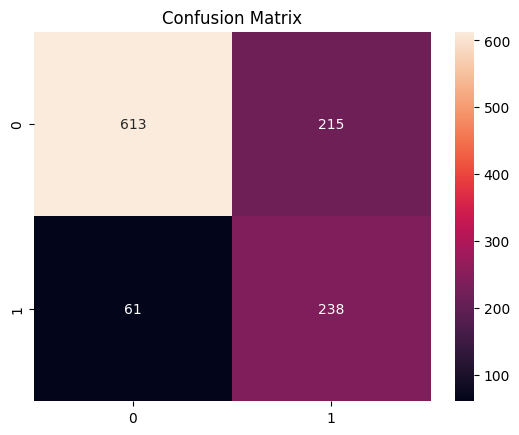

In [30]:

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()
